# LightGBM Model

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Load-Libraries" data-toc-modified-id="Load-Libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Libraries</a></span></li><li><span><a href="#Set-Matplotlib-Options" data-toc-modified-id="Set-Matplotlib-Options-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Set Matplotlib Options</a></span></li><li><span><a href="#Load-data-from-Pickle" data-toc-modified-id="Load-data-from-Pickle-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load data from Pickle</a></span></li><li><span><a href="#Split-the-dataset" data-toc-modified-id="Split-the-dataset-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Split the dataset</a></span></li><li><span><a href="#Prepare-the-parameters-for-lightLGB" data-toc-modified-id="Prepare-the-parameters-for-lightLGB-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Prepare the parameters for lightLGB</a></span></li><li><span><a href="#List-of-features-to-drop" data-toc-modified-id="List-of-features-to-drop-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>List of features to drop</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Model-the-data-using-LightGBM" data-toc-modified-id="Model-the-data-using-LightGBM-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Model the data using LightGBM</a></span></li><li><span><a href="#Model-Results" data-toc-modified-id="Model-Results-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Model Results</a></span></li></ul></div>

## Introduction
In this section we will be building and evaluating a LightGBM model. LightGBM performs both level-wise and leaf-wise (tree grows from particular leaf) training are available. It allows user to select a method called Gradient-based One-Side Sampling (GOSS) that splits the samples based on the largest gradients and some random samples with smaller gradients. The assumption behind is that data points with smaller gradients are more well-trained. Another key algorithm is the Exclusive Feature Bundling (EFB), which looks into the sparsity of features and combines multiple features into one without losing any information given that they are never non-zero together.

## Load Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import gc
import pickle

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.fe_modeling import *

%matplotlib inline

# Set Pandas Options

In [3]:
# Some Pandas options so that we can examine all the columns in the dataset with head
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000
pd.options.display.max_colwidth = 1000

## Set Matplotlib Options

In [4]:
# Set a few plotting defaults
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 12

In [3]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

In [4]:
SEED = 42
seed_everything(SEED)
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
TARGET = 'isFraud'
NFOLDS = 5

## Load data from Pickle

In [5]:
%%time
X = pd.read_pickle('../data/train_reduced.pkl')
X_test = pd.read_pickle('../data/test_reduced.pkl')

y = X[TARGET]
X = X.drop(TARGET, axis=1)
        
print(f'X.shape : {X.shape}, X_test.shape : {X_test.shape}')

X.shape : (590540, 434), X_test.shape : (506691, 434)
Wall time: 7.38 s


## Split the dataset

In [6]:
def train_val_split_by_time(X, y, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=False)
    
    print(f'train.shape: {X_train.shape}, val.shape: {X_val.shape}')
    
    return X_train, y_train, X_val, y_val

In [7]:
X_train, y_train, X_val, y_val = train_val_split_by_time(X, y)

train.shape: (472432, 434), val.shape: (118108, 434)


## Prepare the parameters for lightLGB

In [5]:
lgb_params = {
    'objective': 'binary',
    #'metric': 'auc',
    'metric': 'None',
    'learning_rate': 0.01,
    'num_leaves': 2**8,
    'max_bin': 255,
    'max_depth': -1,
    'bagging_freq': 5,
    'bagging_fraction': 0.7,
    'bagging_seed': SEED,
    'feature_fraction': 0.7,
    'feature_fraction_seed': SEED,
    'first_metric_only': True,
    'verbose': 100,
    'n_jobs': -1,
    'seed': SEED,
}

## List of features to drop
This lis contains temporary features that will be created during the feature engineering stage. They are them dropped when no longer needed.

In [6]:
cols_to_drop = [
    'D5_DT_W_std_score',
    'ProductCD_TransactionAmt_DT_W',
    'D4_DT_D_std_score',
    'D15_DT_D_std_score',
    'D3_DT_W_std_score',
    'D11_DT_W_std_score',
    'card3_card5_DT_W_week_day_dist',
    'card5_DT_W_week_day_dist',
    'D10_DT_D_std_score',
    'card3_card5_DT_D',
    'ProductCD_cents_DT_D',
    'D4_DT_W_std_score',
    'D15_DT_W_std_score',
    'uid_DT_D',
    'card3_DT_W_week_day_dist',
    'D10_DT_W_std_score',
    'D8_DT_D_std_score',
    'card3_card5_DT_W',
    'ProductCD_cents_DT_W',
    'uid_DT_W',
    'D8_DT_W_std_score'
]

## Feature Engineering
This function does the bulk of the feature engineering. These are the most important tasks:
* Identify valid credit cards - those cards that have more than two entries.
* Create timeblocks for use in feature aggregation to examine transactions based on periodic behavior.
* Use feature aggregation to capture behavioral aspects of card transactions.
* Feature encoding.
* Removing temporary and unnecessary features.


In [10]:
X_train, X_val, category_cols1 = fe1(X_train, X_val, cols_to_drop)

Rare data card1 5134
No intersection in Train card1 20399
Intersection in Train card1 452033
####################
Rare data ProductCD_card1 10509
No intersection in Train ProductCD_card1 33115
Intersection in Train ProductCD_card1 439317
####################
Rare data card1_addr1 21640
No intersection in Train card1_addr1 57867
Intersection in Train card1_addr1 414565
####################
Rare data TransactionAmt_dist2 18260
No intersection in Train TransactionAmt_dist2 49343
Intersection in Train TransactionAmt_dist2 423089
####################
No intersection in Train card2 6102
Intersection in Train card2 466330
####################
No intersection in Train card3 146
Intersection in Train card3 472286
####################
No intersection in Train card4 0
Intersection in Train card4 472432
####################
No intersection in Train card5 7339
Intersection in Train card5 465093
####################
No intersection in Train card6 45
Intersection in Train card6 472387
###############

processing nan group agg for: ['V143', 'V144', 'V145', 'V150', 'V151', 'V152', 'V159', 'V160', 'V164', 'V165', 'V166']
processing nan group agg for: ['V167', 'V168', 'V172', 'V173', 'V176', 'V177', 'V178', 'V179', 'V181', 'V182', 'V183', 'V186', 'V187', 'V190', 'V191', 'V192', 'V193', 'V196', 'V199', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216']
processing nan group agg for: ['V169', 'V170', 'V171', 'V174', 'V175', 'V180', 'V184', 'V185', 'V188', 'V189', 'V194', 'V195', 'V197', 'V198', 'V200', 'V201', 'V208', 'V209', 'V210']
processing nan group agg for: ['V217', 'V218', 'V219', 'V223', 'V224', 'V225', 'V226', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V235', 'V236', 'V237', 'V240', 'V241', 'V242', 'V243', 'V244', 'V246', 'V247', 'V248', 'V249', 'V252', 'V253', 'V254', 'V257', 'V258', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278']
processing nan group

In [7]:
X_train = pd.read_pickle('../data/X_train_fe_engineered.pkl')
X_val = pd.read_pickle('../data/X_val_fe_engineered.pkl')

y_train = pd.read_pickle('../data/y_train_fe_engineered.pkl')
y_val = pd.read_pickle('../data/y_val_fe_engineered.pkl')

with open('../data/cat_cols_fe_engineered.pkl', 'rb') as f:
    category_cols1 = pickle.load(f)

## Model the data using LightGBM

(472432, 591) (118108, 591)
Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.983954	valid_1's auc: 0.931672
[400]	training's auc: 0.997135	valid_1's auc: 0.942111
[600]	training's auc: 0.999521	valid_1's auc: 0.945795
[800]	training's auc: 0.999902	valid_1's auc: 0.9473
[1000]	training's auc: 0.999982	valid_1's auc: 0.947937
[1200]	training's auc: 0.999997	valid_1's auc: 0.947979
[1400]	training's auc: 0.999999	valid_1's auc: 0.947848
Early stopping, best iteration is:
[1017]	training's auc: 0.999985	valid_1's auc: 0.94803
Evaluated only: auc
seed: 42 , auc: 0.9480298062192877 , best_iteration: 1017
Training until validation scores don't improve for 500 rounds
[200]	training's auc: 0.983967	valid_1's auc: 0.930058
[400]	training's auc: 0.997097	valid_1's auc: 0.940881
[600]	training's auc: 0.999519	valid_1's auc: 0.944758
[800]	training's auc: 0.999905	valid_1's auc: 0.946551
[1000]	training's auc: 0.999985	valid_1's auc: 0.947161
[1200]	training's 

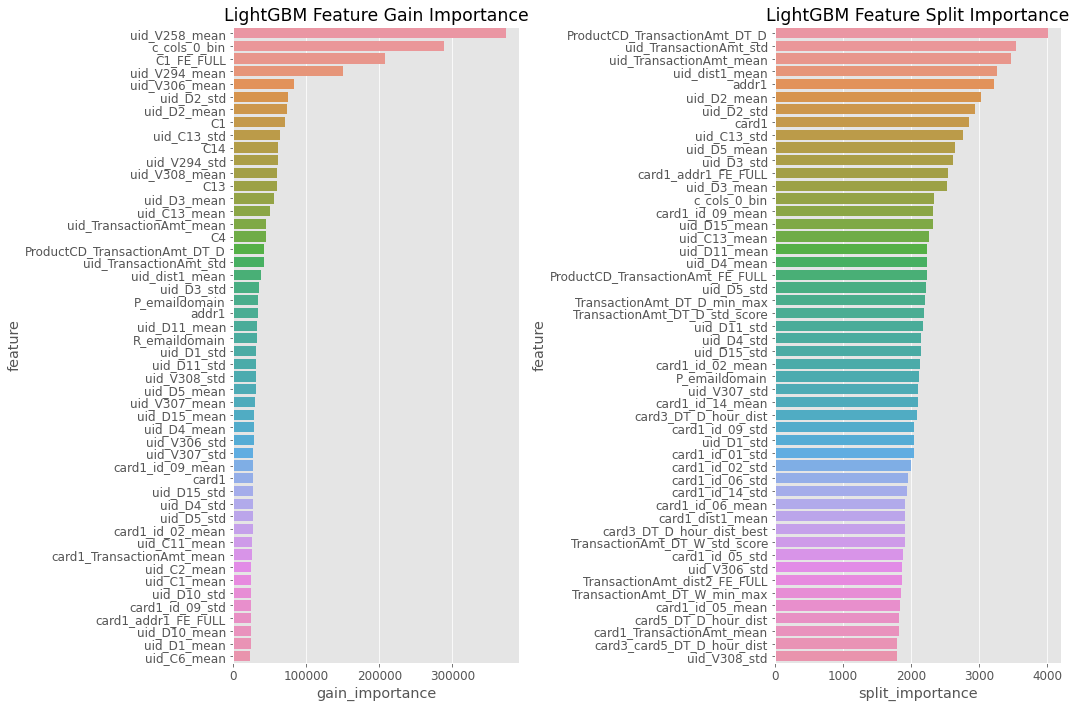

,feature,gain_importance,split_importance
0,ProductCD_TransactionAmt_DT_D,42302.503614,4006.333333
1,uid_TransactionAmt_std,42283.333472,3534.666667
2,uid_TransactionAmt_mean,45840.849060,3461.333333
3,uid_dist1_mean,38809.324286,3260.666667
4,addr1,33638.760238,3224.333333
5,uid_D2_mean,73632.688238,3021.333333
6,uid_D2_std,74753.424259,2933.333333
7,card1,27674.390972,2854.333333
8,uid_C13_std,64244.273298,2764.000000
9,uid_D5_mean,30955.792165,2643.333333


<Figure size 1080x432 with 0 Axes>

In [8]:
fi_df, best_iteration1, val_preds = make_val_prediction(X_train, y_train, X_val, y_val, category_cols=category_cols1,lgb_params=lgb_params)

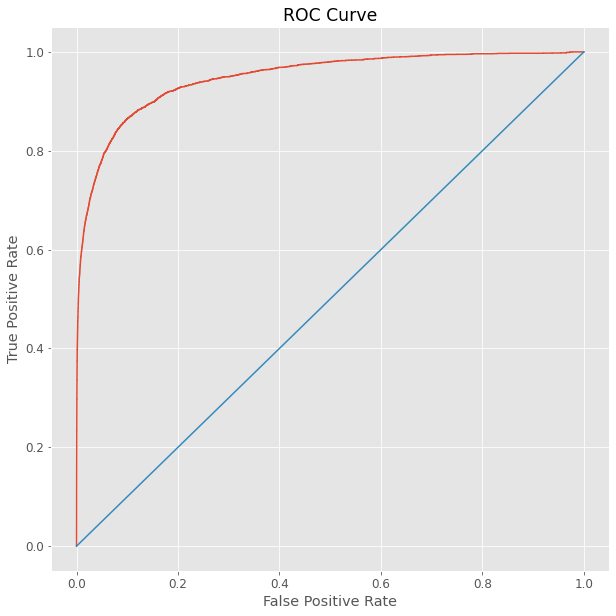

In [12]:
from sklearn.metrics import roc_curve

fpr,tpr,the = roc_curve(y_val,val_preds.mean(axis=1))

plt.figure(figsize=(10,10))
plt.plot(fpr,tpr)
plt.plot(np.arange(0.0,1.2,0.2),np.arange(0.0,1.2,0.2))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

plt.savefig('../images/LGBM_ROC_Curve.png')
plt.show()

## Model Results
The model AUC for both the training and validation sets are quite high, showing that the model is very capable of distinguishing between `fraudulant` and `non fraudulant` transactions.
**avg pred auc: `0.94848`, avg auc: `0.94781+/-0.00016`**<p></p>
The chart shows which features are important with this model. Notice that importance is base on which features give the most information gain over all splits, and which are most important with regards to splits. 

In [13]:
np.save('val_preds_lgb.npy', val_preds)